In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


## Import một số thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
#from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Đọc file csv
df = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.shape

(35887, 3)

### Kiểm tra số lượng ảnh mờ, nhiễu trong dataset

In [5]:
df['pixels_array'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.float32))
df['pixel_mean'] = df['pixels_array'].apply(np.mean)
df['pixel_std'] = df['pixels_array'].apply(np.std)

In [6]:
# Mờ = mean < 40 và std < 15
blurred_df = df[(df['pixel_mean'] < 40) & (df['pixel_std'] < 15)]
print(f"Số lượng ảnh mờ: {len(blurred_df)}")


Số lượng ảnh mờ: 16


In [7]:
# Nhiễu = std > 70
noisy_df = df[df['pixel_std'] > 70]
print(f"Số lượng ảnh nghi nhiễu: {len(noisy_df)}")


Số lượng ảnh nghi nhiễu: 4486


## Xóa ảnh mờ và làm mượt ảnh bị nhiễu

In [8]:
import cv2
import numpy as np
blurred_idx = blurred_df.index  # danh sách index ảnh mờ
noisy_idx = noisy_df.index      # danh sách index ảnh nhiễu
def process_pixel_array(pixels_array, idx, blurred_idx, noisy_idx):
    img = np.array(pixels_array).reshape(48, 48).astype(np.uint8)

    if idx in blurred_idx:
        return None  # Xoá ảnh mờ

    if idx in noisy_idx:
        img = cv2.medianBlur(img, 3)  # Làm mượt ảnh nghi nhiễu

    img = cv2.resize(img, (160, 160), interpolation=cv2.INTER_CUBIC)
    img_rgb = np.stack([img]*3, axis=-1)
    return img_rgb


In [9]:
clean_images = []
clean_labels = []

for idx, row in df.iterrows():
    img = process_pixel_array(row['pixels_array'], idx, blurred_idx, noisy_idx)
    if img is not None:
        clean_images.append(img)
        clean_labels.append(row['emotion'])

## Kiểm tra các ảnh đã xử lý hay chưa

In [10]:
print(f"Tổng số ảnh ban đầu: {len(df)}")

Tổng số ảnh ban đầu: 35887


In [11]:
print(f"Tổng số ảnh sau xử lý: {len(clean_images)}")

Tổng số ảnh sau xử lý: 35871


In [12]:
print(f"Số ảnh mờ bị loại: {len(blurred_idx)}")
print(f"Số ảnh nhiễu được làm mượt: {len(noisy_idx)}")

Số ảnh mờ bị loại: 16
Số ảnh nhiễu được làm mượt: 4486


## Kiểm tra các ảnh bị lỗi

In [13]:
# Thống kê thêm
df['pixel_min'] = df['pixels_array'].apply(np.min)
df['pixel_max'] = df['pixels_array'].apply(np.max)

# Đặt điều kiện loại ảnh lỗi
def is_corrupted(row):
    mean = row['pixel_mean']
    std = row['pixel_std']
    min_val = row['pixel_min']
    max_val = row['pixel_max']
    return (
        mean < 10 or
        mean > 245 or
        std < 5 or
        (max_val - min_val) < 20 or
        max_val < 30 or
        min_val > 225
    )

df['corrupted'] = df.apply(is_corrupted, axis=1)

# Tách ảnh sạch và lỗi
corrupted_df = df[df['corrupted']]
clean_df = df[~df['corrupted']]

print(f"Số ảnh lỗi bị loại bỏ: {len(corrupted_df)}")
print(f"Số ảnh còn lại sau khi loại: {len(clean_df)}")


Số ảnh lỗi bị loại bỏ: 20
Số ảnh còn lại sau khi loại: 35867


## Gán nhãn dữ liệu

In [14]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'sadness',
                5: 'surprise', 6: 'neutral'}

## kiểm tra số ảnh bị gán nhãn sai

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_all_classes(df, label_to_text, n_samples=10, outlier_std_thresh=2):
    from scipy.stats import zscore

    # Tính z-score để tìm outlier
    df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
    df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)

    classes = sorted(df['emotion'].unique())

    for cls in classes:
        print(f"\n Class {cls} - {label_to_text[cls]}")

        # Hiển thị ảnh ngẫu nhiên trong class
        samples = df[df['emotion'] == cls].sample(n_samples, random_state=42)
        print(f" {n_samples} ảnh ngẫu nhiên:")
        for _, row in samples.iterrows():
            img = np.array(row['pixels_array']).reshape(48, 48)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(label_to_text[cls])
            plt.show()

        # Hiển thị các ảnh nghi là outlier theo pixel
        outliers = df[(df['emotion'] == cls) & ((np.abs(df['z_mean']) > outlier_std_thresh) | (np.abs(df['z_std']) > outlier_std_thresh))]
        print(f" Ảnh nghi outlier: {len(outliers)}")
        for _, row in outliers.head(n_samples).iterrows():
            img = np.array(row['pixels_array']).reshape(48, 48)
            plt.imshow(img, cmap='gray')



 Class 0 - Anger
 5 ảnh ngẫu nhiên:


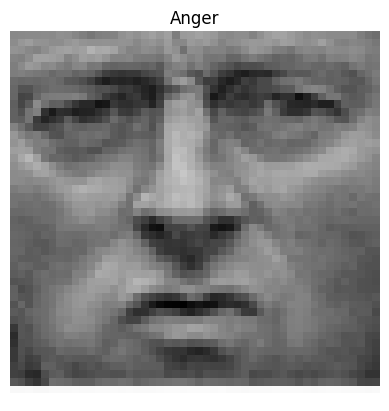

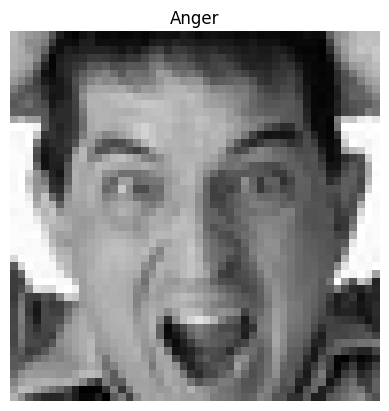

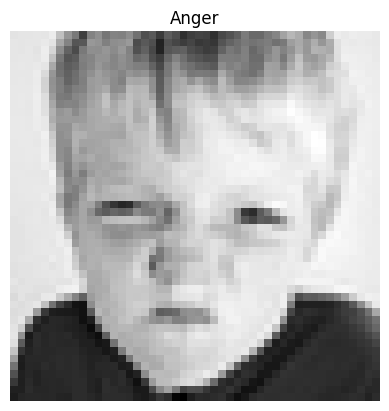

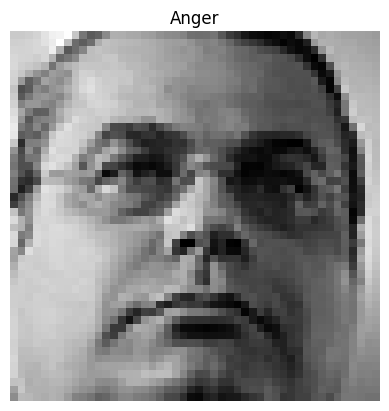

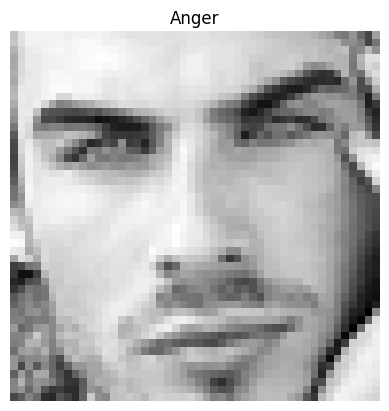

 Ảnh nghi outlier: 397

 Class 1 - Disgust
 5 ảnh ngẫu nhiên:


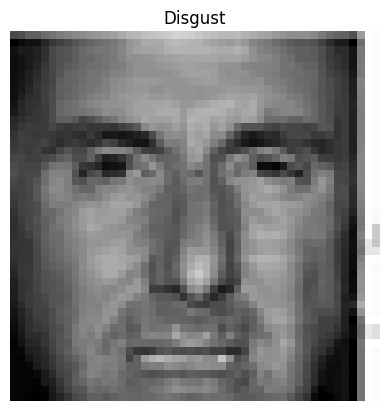

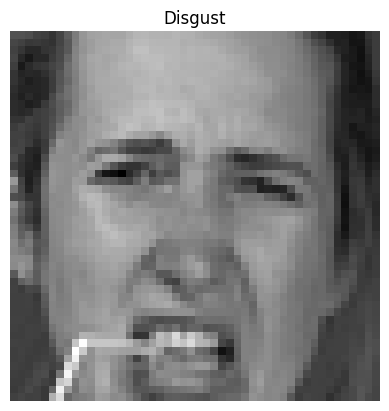

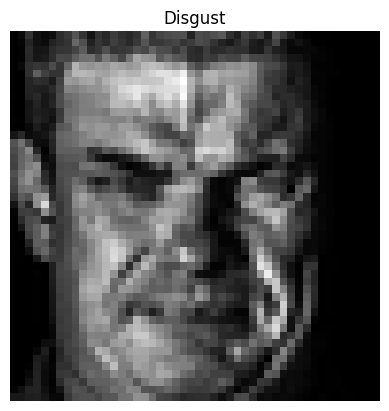

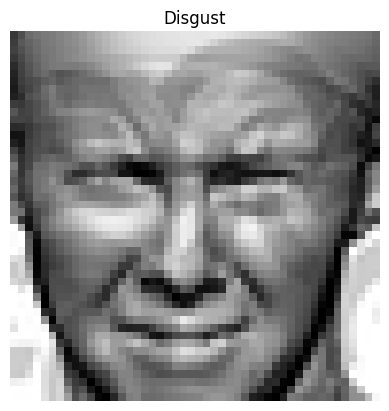

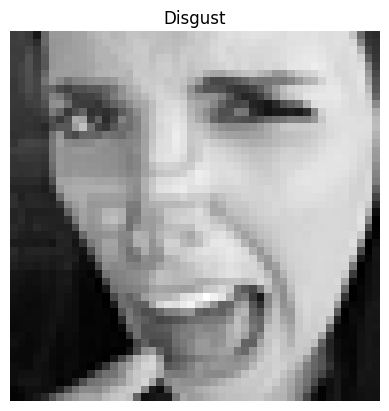

 Ảnh nghi outlier: 34

 Class 2 - Fear
 5 ảnh ngẫu nhiên:


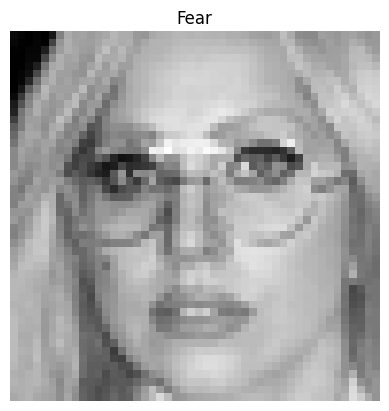

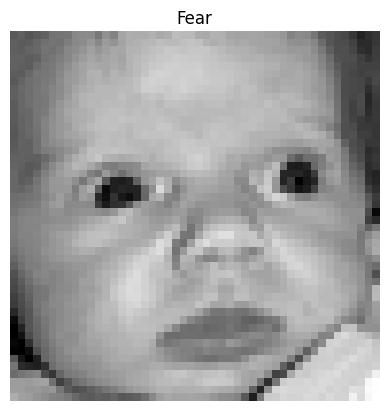

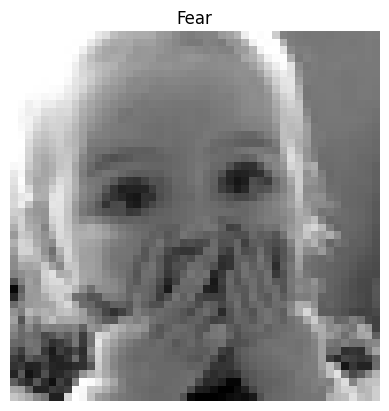

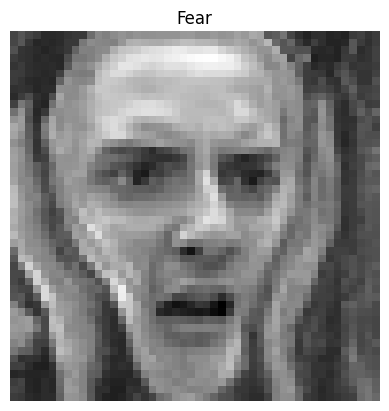

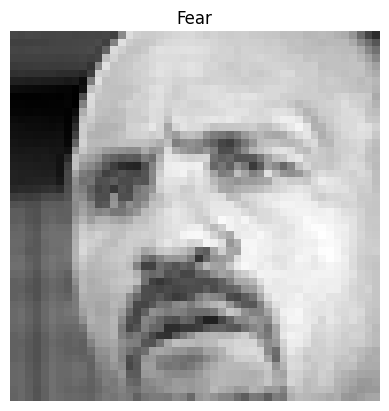

 Ảnh nghi outlier: 378

 Class 3 - Happiness
 5 ảnh ngẫu nhiên:


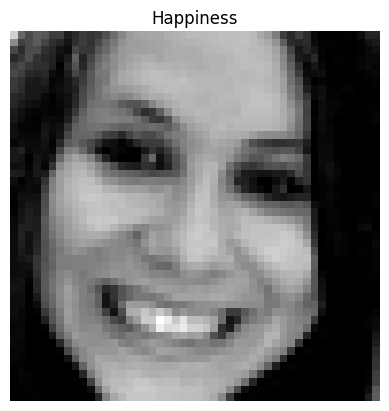

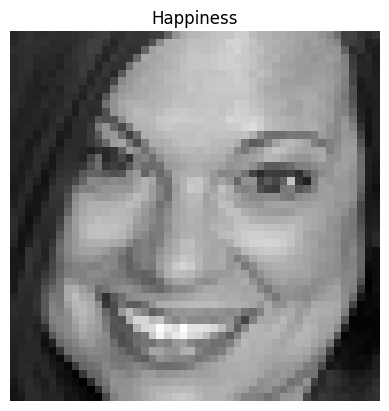

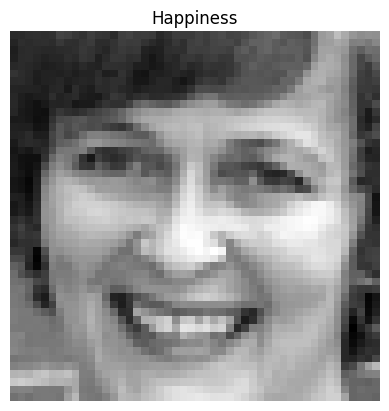

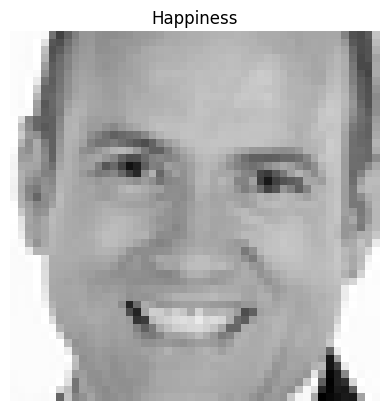

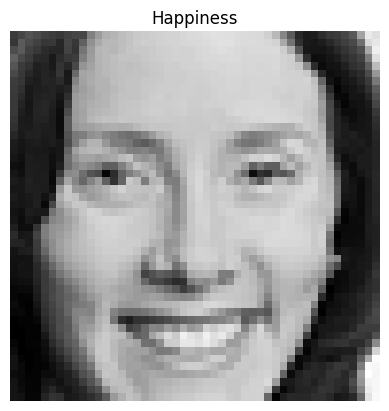

 Ảnh nghi outlier: 722

 Class 4 - sadness
 5 ảnh ngẫu nhiên:


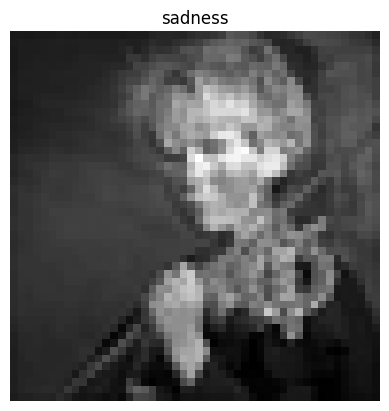

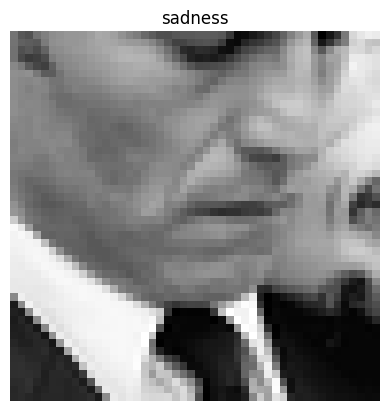

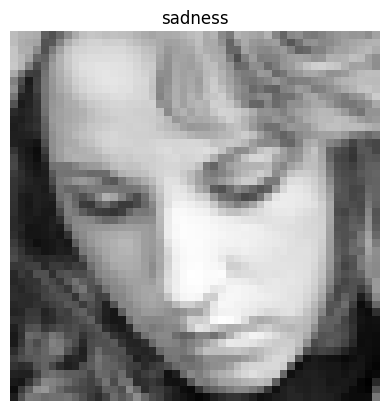

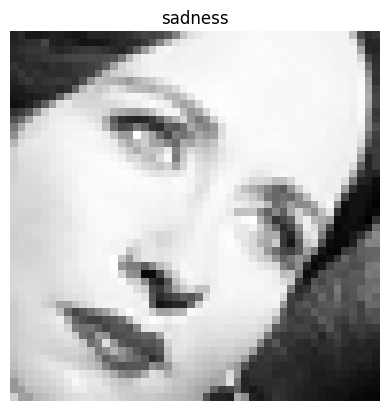

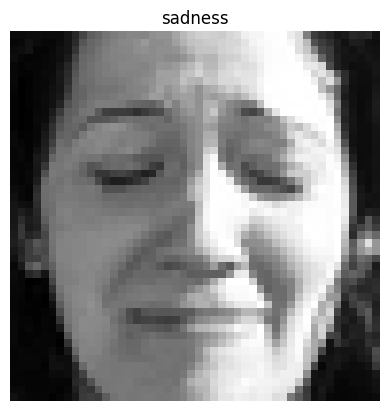

 Ảnh nghi outlier: 502

 Class 5 - surprise
 5 ảnh ngẫu nhiên:


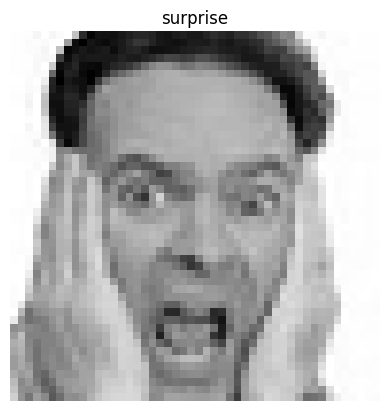

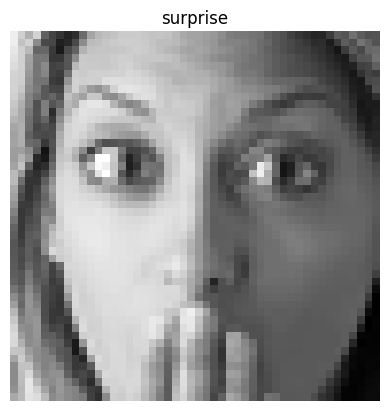

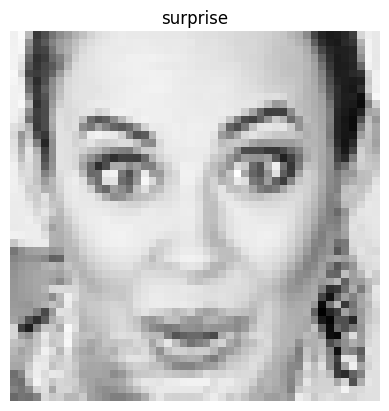

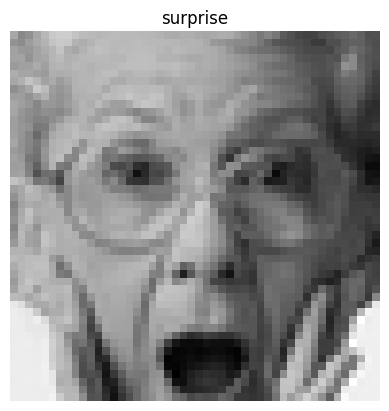

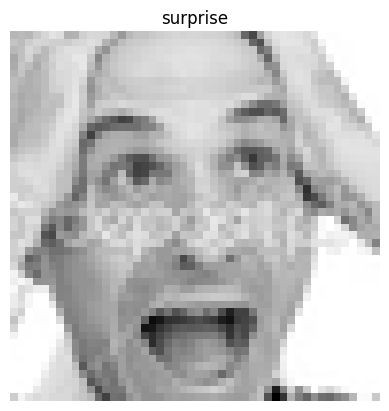

 Ảnh nghi outlier: 301

 Class 6 - neutral
 5 ảnh ngẫu nhiên:


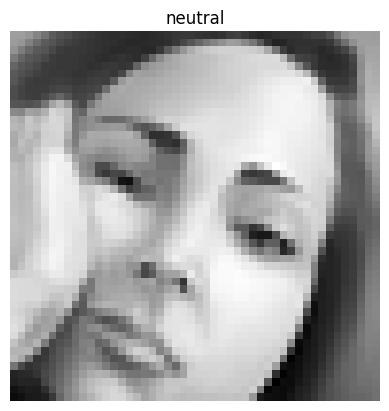

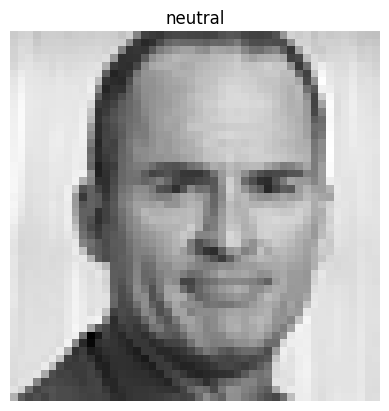

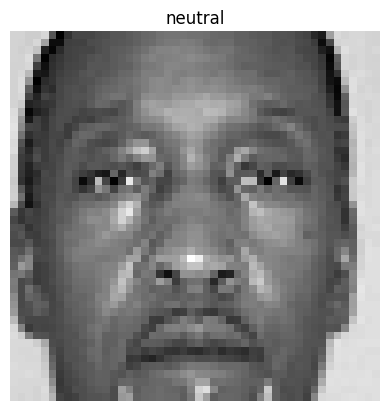

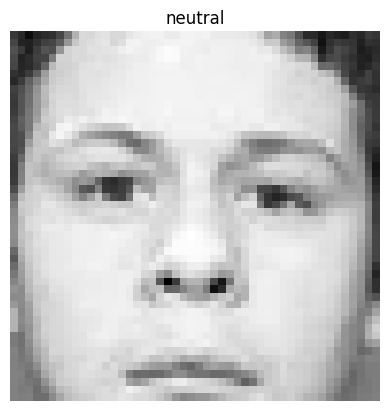

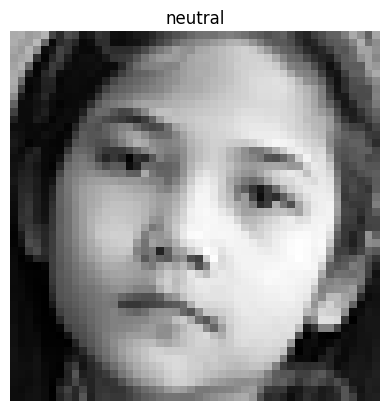

 Ảnh nghi outlier: 478


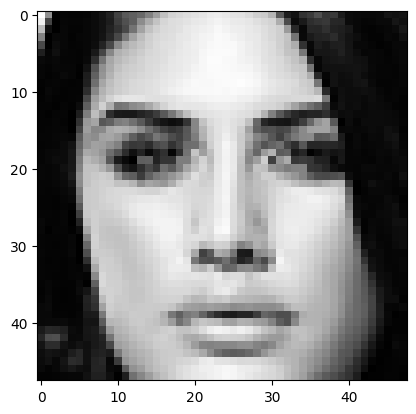

In [16]:
inspect_all_classes(df, label_to_text, n_samples=5, outlier_std_thresh=2)

## Loại bỏ outlier

In [17]:
from scipy.stats import zscore

# Tính z-score theo từng class
df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)


In [18]:
# Tiêu chí loại bỏ: |z-score của pixel_mean| > 2 (hoặc 3)
#hoặc |z-score của pixel_std| > 2 (hoặc 3)
threshold = 2  # hoặc 3 nếu bạn muốn giữ lại nhiều hơn

# Xác định chỉ số outlier
outlier_idx = df[(df['z_mean'].abs() > threshold) | (df['z_std'].abs() > threshold)].index

# Tạo DataFrame sạch
df_clean = df.drop(index=outlier_idx)

print(f"Số ảnh bị loại vì outlier: {len(outlier_idx)}")
print(f"Số ảnh còn lại sau khi lọc: {len(df_clean)}")


Số ảnh bị loại vì outlier: 2812
Số ảnh còn lại sau khi lọc: 33075


## Hiển thị ảnh trước khi training

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# Hiển thị ảnh sau khi xử lý data
def show_clean_samples(df_clean, label_to_text, n_samples=5):
    fig = plt.figure(figsize=(18, 18))
    k = 1
    num_classes = df_clean['emotion'].nunique()

    for label in sorted(df_clean['emotion'].unique()):
        samples = df_clean[df_clean['emotion'] == label].sample(n_samples, random_state=42)

        for _, row in samples.iterrows():
            pixels = np.array(row['pixels_array']).reshape(48, 48)  # giả sử bạn đã có pixels_array
            ax = plt.subplot(num_classes, n_samples, k)
            ax.imshow(pixels, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label_to_text[label])
            k += 1

    plt.tight_layout()
    plt.show()


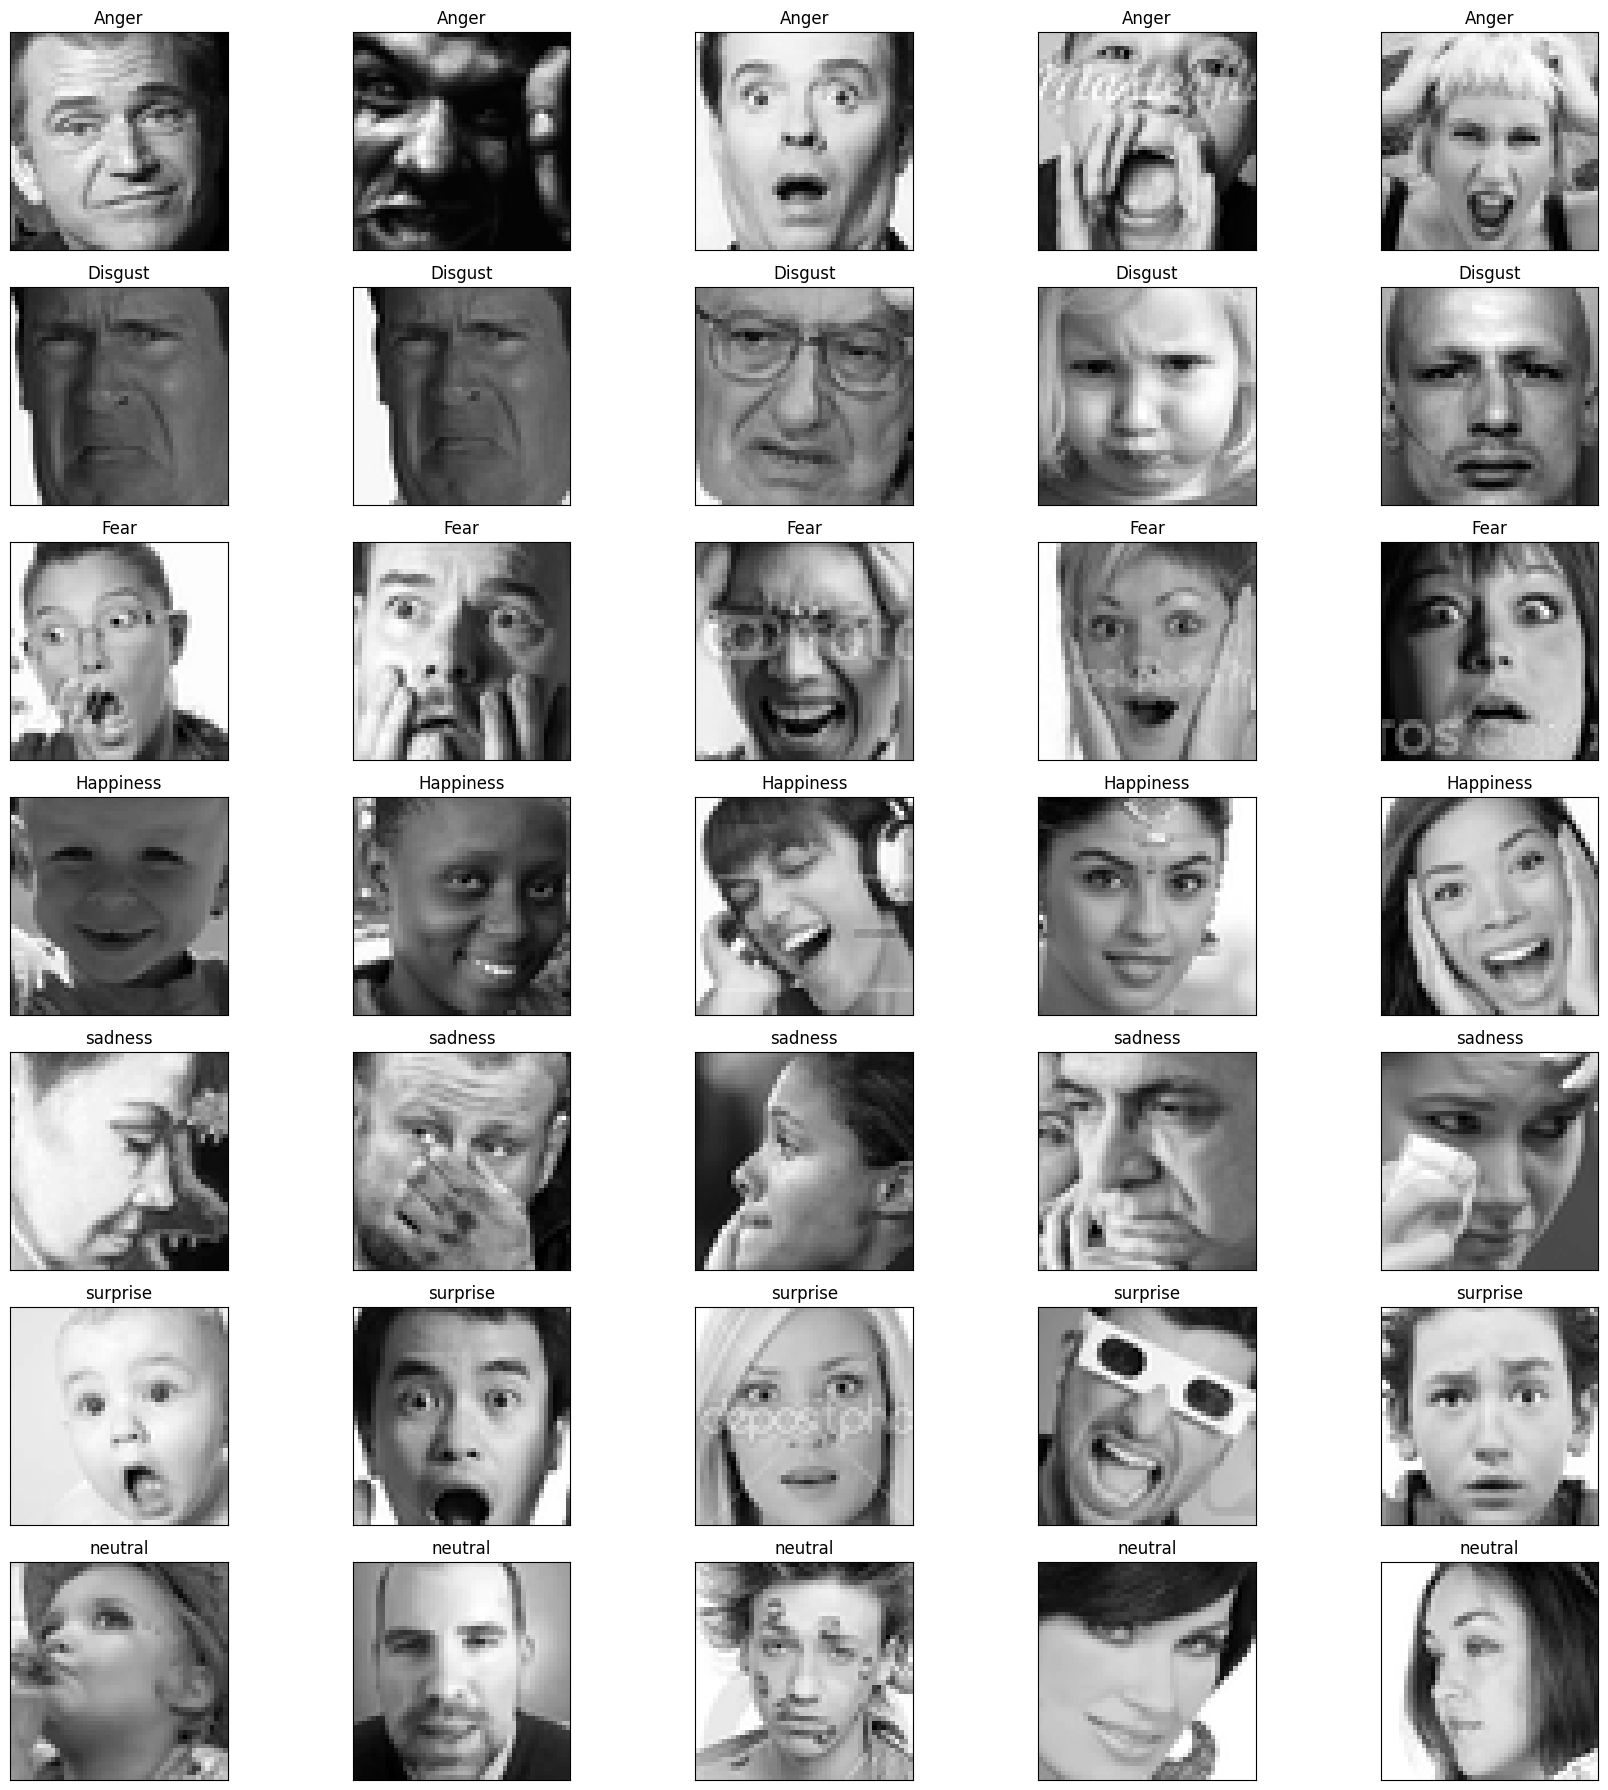

In [20]:
show_clean_samples(df_clean, label_to_text, n_samples=5)

## Số lượng emotion ở mỗi class

In [21]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [22]:
# Split the data into features and target variable

X_data = df['pixels']
y_data = df['emotion']

In [23]:
df.isnull().sum()

emotion         0
pixels          0
Usage           0
pixels_array    0
pixel_mean      0
pixel_std       0
pixel_min       0
pixel_max       0
corrupted       0
z_mean          0
z_std           0
dtype: int64

In [24]:
X_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35887, dtype: object

In [25]:
# Normalize the data
x_data = np.array(list(map(str.split, X_data)), np.float32)
x_data

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]], dtype=float32)

In [26]:
x_data = x_data/255

In [27]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(35887, 48, 48, 1)

In [28]:
# Split the data into train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.2, random_state = 42)

In [29]:
x_train.shape, x_test.shape, y_train.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709,))

In [30]:
from keras.utils import to_categorical

2025-07-08 14:30:51.692295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751985051.713559     302 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751985051.719789     302 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [31]:
# Perfom one-hot encoding on labels
y_train_encoded = to_categorical(y_train, 7)
y_train_encoded.shape

(28709, 7)

In [32]:
y_test_encoded = to_categorical(y_test, 7)
y_test_encoded.shape

(7178, 7)

In [33]:
x_data_rgb = np.repeat(x_data, 3, axis=-1)  # chuyển (48, 48, 1) → (48, 48, 3)


In [34]:
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)


In [35]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
# Dataset class từ clean_images & clean_labels
class FERCleanDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

        return image, label


In [36]:
import torchvision.transforms as transforms
from torchvision import transforms

#Transform chuẩn ResNet50
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [ ]:
train_dataset = FERCleanDataset(X_train, y_train, transform=train_transform)
val_dataset = FERCleanDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [37]:
def calculate_class_weights(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())

    import numpy as np
    class_counts = np.bincount(np.array(all_labels))
    total = len(all_labels)
    n_classes = len(class_counts)
    weights = total / (n_classes * class_counts)
    return torch.FloatTensor(weights)


In [39]:
import torch
import torch.nn.functional as F

def mixup_data(x, y, alpha=1.0):
    """Trộn dữ liệu đầu vào và nhãn bằng Mixup."""
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [40]:
# Loss Mixup
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Model 

In [44]:
import torch.nn as nn
import torchvision.models as models

def get_pretrained_resnet50(num_classes=7):
    # Tải mô hình ResNet50 pretrained trên ImageNet
    model = models.resnet50(pretrained=True)

    # Freeze các layer đầu (tuỳ chọn nếu bạn muốn fine-tune nhẹ nhàng)
    for param in model.parameters():
        param.requires_grad = False

    # Chỉ fine-tune phần FC cuối cùng
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

    return model


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_pretrained_resnet50().to(device)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [47]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f" EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [48]:
from tqdm import tqdm


# === Evaluate ===
def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy
# === Train ===
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
early_stopping = EarlyStopping(patience=8, verbose=True)
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1} — Current LR: {current_lr:.6f}")

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # === Mixup ===
        images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()

        # Accuracy tính theo y_a
        _, predicted = outputs.max(1)
        correct += (predicted == y_a).sum().item()
        total += labels.size(0)

        running_loss += loss.item() * images.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        loop.set_postfix(loss=train_loss, acc=train_acc)

    # === Validation ===
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Ghi log
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Scheduler & EarlyStopping
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(" Early stopping triggered.")
        break

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50.pth")
        print(" Saved best model")

print(" Best Validation Accuracy:", best_acc)


Epoch 1 — Current LR: 0.001000


Epoch 1/100 [Train]: 100%|██████████| 3589/3589 [06:40<00:00,  8.96it/s, acc=0.246, loss=1.84]


Validation Loss: 1.8245, Accuracy: 0.2505

Epoch 2 — Current LR: 0.001000


Epoch 2/100 [Train]: 100%|██████████| 3589/3589 [06:41<00:00,  8.95it/s, acc=0.257, loss=1.81]


Validation Loss: 1.7027, Accuracy: 0.3355

Epoch 3 — Current LR: 0.001000


Epoch 3/100 [Train]: 100%|██████████| 3589/3589 [06:40<00:00,  8.96it/s, acc=0.312, loss=1.68]


Validation Loss: 1.5537, Accuracy: 0.4380

Epoch 4 — Current LR: 0.001000


Epoch 4/100 [Train]: 100%|██████████| 3589/3589 [06:39<00:00,  8.98it/s, acc=0.337, loss=1.59]


Validation Loss: 1.4563, Accuracy: 0.4923

Epoch 5 — Current LR: 0.001000


Epoch 5/100 [Train]: 100%|██████████| 3589/3589 [06:39<00:00,  8.99it/s, acc=0.364, loss=1.54]


Validation Loss: 1.5128, Accuracy: 0.4675
 EarlyStopping counter: 1/8

Epoch 6 — Current LR: 0.001000


Epoch 6/100 [Train]: 100%|██████████| 3589/3589 [06:38<00:00,  9.01it/s, acc=0.369, loss=1.52]


Validation Loss: 1.4138, Accuracy: 0.5155

Epoch 7 — Current LR: 0.001000


Epoch 7/100 [Train]: 100%|██████████| 3589/3589 [06:37<00:00,  9.02it/s, acc=0.381, loss=1.5]


Validation Loss: 1.3762, Accuracy: 0.5325

Epoch 8 — Current LR: 0.001000


Epoch 8/100 [Train]: 100%|██████████| 3589/3589 [06:38<00:00,  9.02it/s, acc=0.385, loss=1.49]


Validation Loss: 1.3589, Accuracy: 0.5383

Epoch 9 — Current LR: 0.001000


Epoch 9/100 [Train]: 100%|██████████| 3589/3589 [06:37<00:00,  9.03it/s, acc=0.389, loss=1.46]


Validation Loss: 1.3159, Accuracy: 0.5617

Epoch 10 — Current LR: 0.001000


Epoch 10/100 [Train]: 100%|██████████| 3589/3589 [06:37<00:00,  9.03it/s, acc=0.398, loss=1.45]


Validation Loss: 1.3163, Accuracy: 0.5645
 EarlyStopping counter: 1/8

Epoch 11 — Current LR: 0.001000


Epoch 11/100 [Train]: 100%|██████████| 3589/3589 [06:37<00:00,  9.03it/s, acc=0.4, loss=1.44]  


Validation Loss: 1.2930, Accuracy: 0.5815

Epoch 12 — Current LR: 0.001000


Epoch 12/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.04it/s, acc=0.416, loss=1.42]


Validation Loss: 1.2885, Accuracy: 0.5921

Epoch 13 — Current LR: 0.001000


Epoch 13/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.04it/s, acc=0.412, loss=1.41]


Validation Loss: 1.2804, Accuracy: 0.5890

Epoch 14 — Current LR: 0.001000


Epoch 21/100 [Train]: 100%|██████████| 3589/3589 [06:37<00:00,  9.04it/s, acc=0.435, loss=1.35]


Validation Loss: 1.2246, Accuracy: 0.6188

Epoch 22 — Current LR: 0.001000


Epoch 22/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.05it/s, acc=0.435, loss=1.34]


Validation Loss: 1.2343, Accuracy: 0.6166
 EarlyStopping counter: 1/8

Epoch 23 — Current LR: 0.001000


Epoch 23/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.06it/s, acc=0.43, loss=1.33] 


Validation Loss: 1.2186, Accuracy: 0.6297

Epoch 24 — Current LR: 0.001000


Epoch 24/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.06it/s, acc=0.441, loss=1.32]


Validation Loss: 1.2199, Accuracy: 0.6152
 EarlyStopping counter: 1/8

Epoch 25 — Current LR: 0.001000


Epoch 25/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.06it/s, acc=0.445, loss=1.32]


Validation Loss: 1.2084, Accuracy: 0.6308

Epoch 26 — Current LR: 0.001000


Epoch 26/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.06it/s, acc=0.444, loss=1.31]


Validation Loss: 1.2007, Accuracy: 0.6372

Epoch 27 — Current LR: 0.001000


Epoch 27/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.448, loss=1.31]


Validation Loss: 1.2074, Accuracy: 0.6283
 EarlyStopping counter: 1/8

Epoch 28 — Current LR: 0.001000


Epoch 28/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.45, loss=1.3]  


Validation Loss: 1.2048, Accuracy: 0.6403
 EarlyStopping counter: 2/8

Epoch 29 — Current LR: 0.001000


Epoch 29/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.448, loss=1.3]


Validation Loss: 1.2102, Accuracy: 0.6372
 EarlyStopping counter: 3/8

Epoch 30 — Current LR: 0.000500


Epoch 30/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.466, loss=1.27]


Validation Loss: 1.1731, Accuracy: 0.6545

Epoch 31 — Current LR: 0.000500


Epoch 31/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.468, loss=1.25]


Validation Loss: 1.1612, Accuracy: 0.6581

Epoch 32 — Current LR: 0.000500


Epoch 32/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.474, loss=1.24]


Validation Loss: 1.1677, Accuracy: 0.6481
 EarlyStopping counter: 1/8

Epoch 33 — Current LR: 0.000500


Epoch 33/100 [Train]: 100%|██████████| 3589/3589 [06:34<00:00,  9.09it/s, acc=0.479, loss=1.24]


Validation Loss: 1.1617, Accuracy: 0.6528
 EarlyStopping counter: 2/8

Epoch 34 — Current LR: 0.000500


Epoch 34/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.475, loss=1.23]


Validation Loss: 1.1567, Accuracy: 0.6553

Epoch 35 — Current LR: 0.000500


Epoch 35/100 [Train]: 100%|██████████| 3589/3589 [06:36<00:00,  9.06it/s, acc=0.484, loss=1.22]


Validation Loss: 1.1686, Accuracy: 0.6584
 EarlyStopping counter: 1/8

Epoch 36 — Current LR: 0.000500


Epoch 36/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.483, loss=1.22]


Validation Loss: 1.1592, Accuracy: 0.6584
 EarlyStopping counter: 2/8

Epoch 37 — Current LR: 0.000500


Epoch 37/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.485, loss=1.22]


Validation Loss: 1.1715, Accuracy: 0.6567
 EarlyStopping counter: 3/8

Epoch 38 — Current LR: 0.000250


Epoch 38/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.486, loss=1.19]


Validation Loss: 1.1475, Accuracy: 0.6668

Epoch 39 — Current LR: 0.000250


Epoch 39/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.494, loss=1.18]


Validation Loss: 1.1605, Accuracy: 0.6576
 EarlyStopping counter: 1/8

Epoch 40 — Current LR: 0.000250


Epoch 40/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.5, loss=1.18]  


Validation Loss: 1.1432, Accuracy: 0.6723

Epoch 41 — Current LR: 0.000250


Epoch 41/100 [Train]: 100%|██████████| 3589/3589 [06:34<00:00,  9.09it/s, acc=0.498, loss=1.17]


Validation Loss: 1.1491, Accuracy: 0.6670
 EarlyStopping counter: 1/8

Epoch 42 — Current LR: 0.000250


Epoch 42/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.495, loss=1.17]


Validation Loss: 1.1517, Accuracy: 0.6637
 EarlyStopping counter: 2/8

Epoch 43 — Current LR: 0.000250


Epoch 43/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.504, loss=1.17]


Validation Loss: 1.1494, Accuracy: 0.6718
 EarlyStopping counter: 3/8

Epoch 44 — Current LR: 0.000125


Epoch 44/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.502, loss=1.15]


Validation Loss: 1.1471, Accuracy: 0.6726
 EarlyStopping counter: 4/8

Epoch 45 — Current LR: 0.000125


Epoch 45/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.504, loss=1.15]


Validation Loss: 1.1464, Accuracy: 0.6748
 EarlyStopping counter: 5/8

Epoch 46 — Current LR: 0.000125


Epoch 46/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.51, loss=1.15] 


Validation Loss: 1.1503, Accuracy: 0.6695
 EarlyStopping counter: 6/8

Epoch 47 — Current LR: 0.000063


Epoch 47/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.08it/s, acc=0.509, loss=1.15]


Validation Loss: 1.1476, Accuracy: 0.6721
 EarlyStopping counter: 7/8

Epoch 48 — Current LR: 0.000063


Epoch 48/100 [Train]: 100%|██████████| 3589/3589 [06:35<00:00,  9.07it/s, acc=0.514, loss=1.12]


Validation Loss: 1.1448, Accuracy: 0.6709
 EarlyStopping counter: 8/8
Early stopping triggered.


## Đánh giá trên tập test

In [54]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 1.1302
Test Accuracy: 0.6885


## Biểu đồ sau khi huấn luyện 

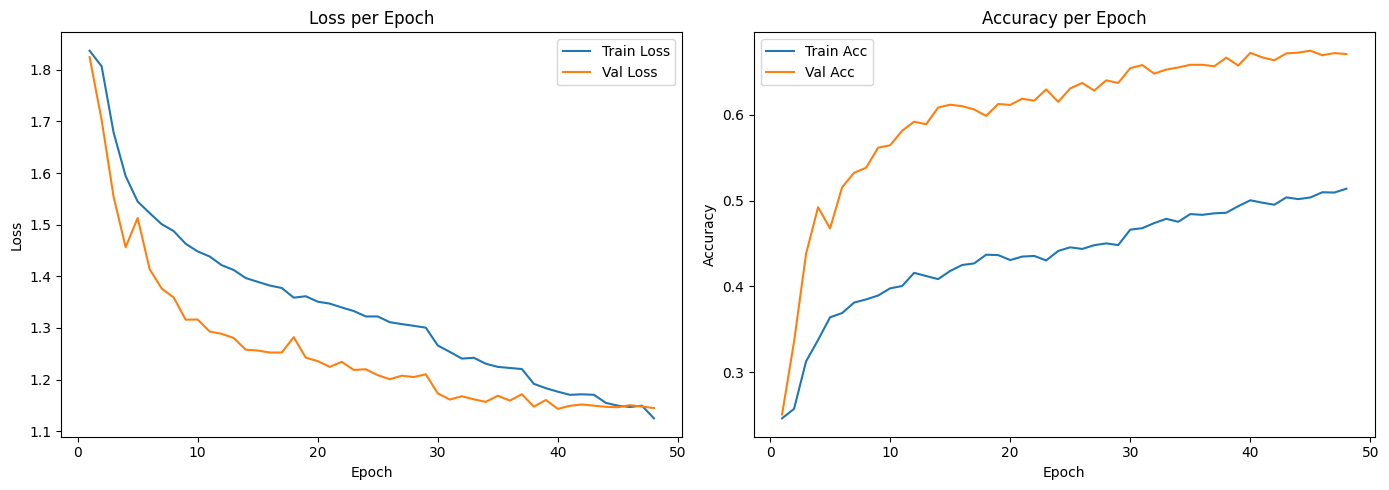

In [55]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


## Ma trận nhầm lẫn


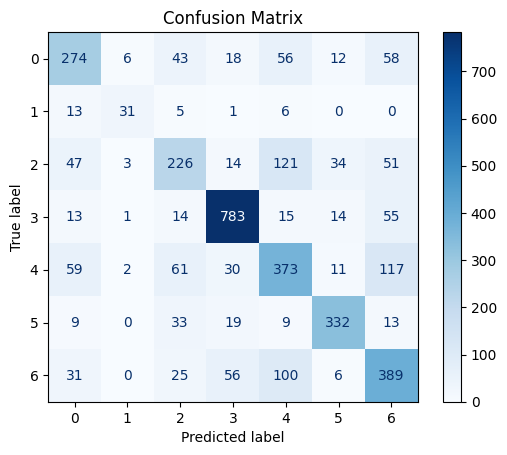

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Dự đoán trên tập validation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Predict ảnh sau khi test

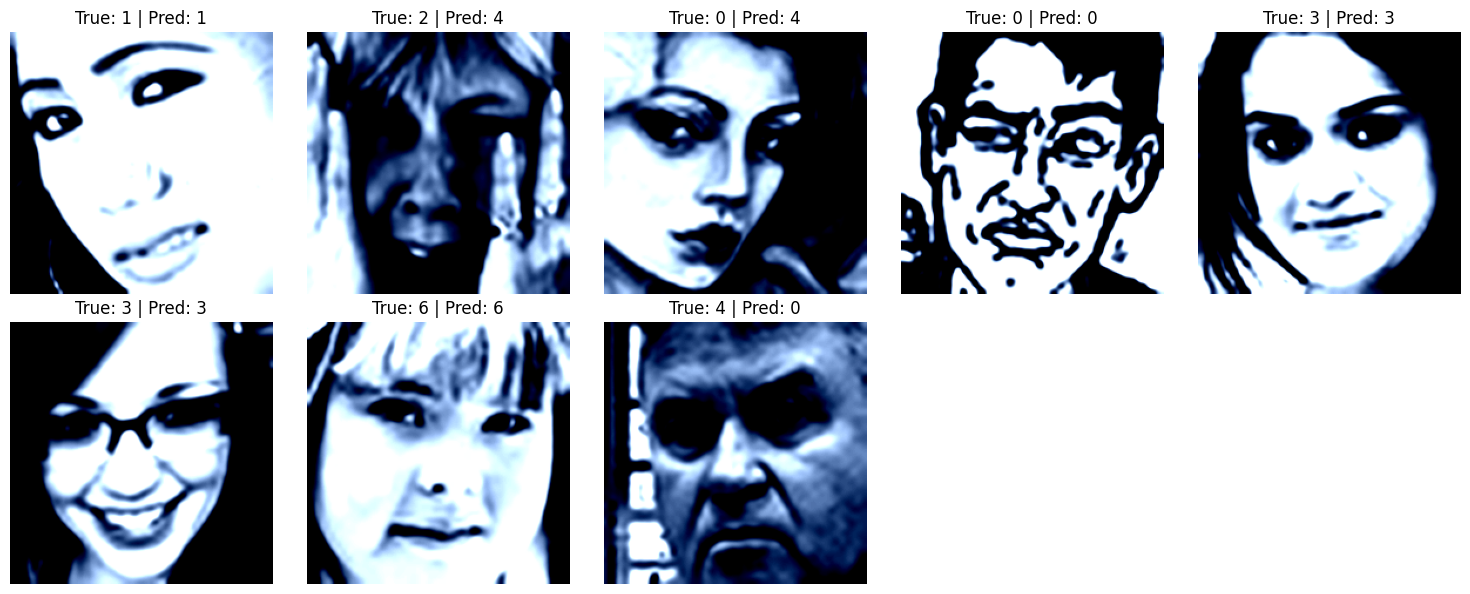

In [52]:
import matplotlib.pyplot as plt
import random
import torch

# Đặt model về chế độ đánh giá
model.eval()

# Lấy 1 batch từ val_loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Dự đoán
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Chọn ngẫu nhiên 10 ảnh (hoặc ít hơn nếu batch < 10)
num_samples = min(10, len(images))
indices = random.sample(range(len(images)), num_samples)

# Hiển thị ảnh
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    image = images[idx].cpu()
    true_label = labels[idx].item()
    predicted_label = preds[idx].item()

    # Chuyển về HWC nếu có 3 kênh
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    elif image.shape[0] == 1:  # Nếu là ảnh xám
        image = image.squeeze(0)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Lưu model

In [53]:
torch.save(model.state_dict(),"Final_Project_DPL302m_ResNet.h5")
print(" Hoàn tất ")

 Hoàn tất 
